In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.auto import tqdm

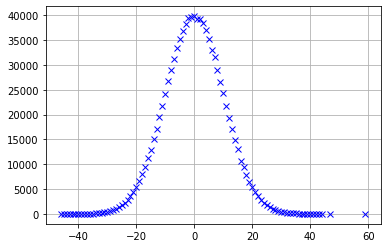

In [8]:
k = np.random.normal(0,10,size=1000000)

def plot_distribution(k):
    k = np.round(k).reshape(-1,)
    plt.plot(Counter(k).keys(),Counter(k).values(),"bx")
    plt.grid()
    
plot_distribution(k)

In [9]:
m = 640
n = 256
q = 113
sigma = 1/n*q
seed = 69

np.random.seed(seed)
A = np.round(np.random.rand(m,n)).astype(int)
S = np.round(np.random.rand(n,1)).astype(int)

generate_e = lambda sig: np.round(np.random.normal(0,sig,size=m).reshape(m,1)).astype(int)
e = generate_e(sigma)

b = (A@S % q + e % q) % q

In [10]:
print(f"min: {b.min()}\nmax: {b.max()}")

min: 48
max: 77


In [ ]:
lstsq_sol = np.linalg.lstsq(A,b,rcond=0)[0]
plot_distribution(lstsq_sol)

In [18]:
thresh = 0.5
lstsq_sol[lstsq_sol>thresh]=1
lstsq_sol[lstsq_sol<thresh]=0

In [19]:
accuracy = lambda x,y: (x==y).sum()/len(y)*100
accuracy(lstsq_sol,S)

100.0

In [11]:
try:
    atainv = np.linalg.inv(A.T@A)
    pred_knownE = np.round(atainv@A.T@(b-e)).astype(int)
    pred_unknownE = np.round(atainv@A.T@(b-generate_e(sigma))).astype(int)
    print(accuracy(pred_knownE,S),accuracy(pred_unknownE,S),sep='\n')
except np.linalg.LinAlgError:
    print("A.T@A is not invertible")

100.0
46.875


# Testing a scoring based method

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

generate_b = lambda sig: (A@S + generate_e(sig)) % q
accuracy = lambda x,y: (x==y).sum()/len(y)*100
print_minmax = lambda b: print(f"min: {b.min()}\nmax: {b.max()}")

m,n,q = 640,256,113
def initialize_expt(m=m,n=n,q=q,sigma_factor=0.05,seed=69):
    global generate_e

    sigma = sigma_factor*q
    np.random.seed(seed)
    A = np.round(np.random.rand(m,n)).astype(int)
    S = np.round(np.random.rand(n,1)).astype(int)


    generate_e = lambda sig: np.round(np.random.normal(0,sig,size=m).reshape(m,1)).astype(int)
    e = generate_e(sigma)

    b = (A@S + e) % q
    print_minmax(b)

    return A,S,e,b,sigma

In [23]:
A,S,e,b,sigma = initialize_expt()

min: 33
max: 82


## Testing, with S known

In [35]:
scores = {i: {0: 0, 1:0} for i in range(A.shape[1])}
acc = []

pbar = tqdm(range(10000), ncols=100)
pbar.set_description(f"Acc: {str(0).zfill(2)}%")

for i in pbar:
    b_ = (b - generate_e(sigma)) % q
    sol = np.linalg.lstsq(A,b_,rcond=0)[0]

    thresh = sol.mean()
    sol[sol>thresh] = 1
    sol[sol<=thresh] = 0

    acc.append(accuracy(sol,S))
    for s in range(len(S)):
        if S[s] == sol[s]:
            scores[s][sol[s][0]] += 1
    
    pbar.set_description(f"Acc: {acc[-1]}%")
    # if acc[-1] > 90: 
    #     print(i)

Acc: 73.046875%: 100%|████████████████████████████████████████| 10000/10000 [19:38<00:00,  8.48it/s]


In [45]:
prediction = []
for key in scores.keys():
    z = scores[key][0]
    o = scores[key][1]

    prediction.append(1 if o>z else 0)

In [47]:
(np.array(prediction).reshape(-1,1)==S).all()

True

## Without knowledge of S 

In [28]:
A,S,e,b,sigma = initialize_expt(sigma_factor=0.01,seed=420)
print_minmax(e)

min: 48
max: 85
min: -3
max: 4


In [46]:
iter_milestones = [1000,5000,10000]
scores = np.zeros((A.shape[1],2))
milestone_acc = []
acc = []

for i in tqdm(range(1,100+1,1),ncols=100):
    b_ = (b - generate_e(sigma)) % q
    sol = np.linalg.lstsq(A,b_,rcond=0)[0]

    thresh = sol.mean()
    sol[sol>thresh] = 1
    sol[sol<=thresh] = 0

    for n,s in enumerate(sol):
        scores[n][int(s)] += 1
    
    temp_sol = np.argmax(scores,axis=1).reshape(-1,1)
    acc.append(accuracy(temp_sol,S))

100%|█████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.72it/s]


In [47]:
scores

array([[ 99.,   1.],
       [  0., 100.],
       [  0., 100.],
       [100.,   0.],
       [100.,   0.],
       [  0., 100.],
       [ 99.,   1.],
       [100.,   0.],
       [  0., 100.],
       [  0., 100.],
       [100.,   0.],
       [  0., 100.],
       [100.,   0.],
       [100.,   0.],
       [  0., 100.],
       [100.,   0.],
       [  0., 100.],
       [  0., 100.],
       [100.,   0.],
       [  0., 100.],
       [  0., 100.],
       [  0., 100.],
       [  0., 100.],
       [ 99.,   1.],
       [  0., 100.],
       [100.,   0.],
       [  0., 100.],
       [  0., 100.],
       [  0., 100.],
       [  0., 100.],
       [  0., 100.],
       [100.,   0.],
       [100.,   0.],
       [100.,   0.],
       [100.,   0.],
       [  0., 100.],
       [  0., 100.],
       [100.,   0.],
       [ 99.,   1.],
       [  0., 100.],
       [ 99.,   1.],
       [100.,   0.],
       [100.,   0.],
       [100.,   0.],
       [  0., 100.],
       [100.,   0.],
       [100.,   0.],
       [  0.,

In [48]:
(scores.argmax(axis=1)==S.reshape(-1,)).all()

True

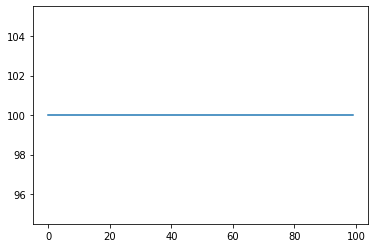

In [49]:
plt.plot(acc)
plt.show()

# Encryption using LWE

In [197]:
A,S,e,b,sigma = initialize_expt(q,seed=69)

77 48


In [254]:
def encrypt_using_lwe(M,A,S,b,q,seed=SEED):
    r = np.round(np.random.rand(A.shape[0])).reshape(1,-1)
    c0 = r@A % q
    c1 = r@b + (M * np.round(q/2))
    c1 = c1 % q

    return c0, c1

def decryt_lwe(c0,c1,A,S,b,q):
    Mdash = (c1 - c0@S) % q

    return int(abs(Mdash) > abs(np.ceil(q/2)-Mdash))

In [299]:
c0,c1 = encrypt_using_lwe(0,A,S,b,q,seed=np.random.randint(1))
Mdash = (c1 - c0@S) % q
int(abs(Mdash) > abs(np.ceil(q/2)-Mdash))

1

In [308]:
(c1 - c0@S) % q

array([[112.]])

In [245]:
decryt_lwe(c0,c1,A,S,b,q)

1

In [246]:
def encrypt_decrypt_cycle(M,A,S,b,q,seed=SEED,iter=10000):
    outputs = []
    for M_ in M:
        c0, c1 = encrypt_using_lwe(M_,A,S,b,q,seed)
        outputs.append(decryt_lwe(c0,c1,A,S,b,q)==M_)

    return 100*np.sum(outputs)/len(outputs)